In [1]:
###Packages & Setup###

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

from shapely.geometry import Point
from matplotlib.collections import PatchCollection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline 

In [2]:
###Load in data###

avocado = pd.read_csv('avocado.csv')
cities = pd.read_csv('uscities.csv')
country = gpd.read_file('gz_2010_us_040_00_5m.json')

In [3]:
###Standardizing city names so we get all of the cities we want when we merge###

cities.city = cities.city.str.replace(' ', '').str.lower()
avocado.region = avocado.region.str.lower()

###Merge###

data = avocado.merge(cities, left_on='region', right_on='city', how='left')

In [4]:
###Cleaning up data###

country = country[(country['NAME'] != 'Alaska') & (country['NAME'] != 'Puerto Rico') & (country['NAME'] != 'Hawaii')]

data = data[(data['city'] != 'west') & (data['city'] != 'california') & (data['city'] != 'plains')
            & (data['city'] != 'northeast') & (data['population'] > 100000) & (data['state_name'] != 'Maine')]
data = data.loc[~((data['state_name'] == 'North Carolina') & (data['city'] == 'jacksonville')),:]
data = data.loc[~((data['state_name'] == 'Georgia') & (data['city'] == 'columbus')),:]

In [16]:
###Zipping Latitude and Longitude###

data = data[(data['lng'] < 0) & (data['lng'] > -140)]
df = data
data['coordinates'] = [
    Point(long, lat) 
    for long, lat 
    in zip(data['lng'], data['lat'])
]
data = gpd.GeoDataFrame(data, geometry='coordinates')
df['Total Volume'].max()

5470227.08

In [6]:
# plotly test

#df = data
#fig = px.scatter_geo(df)

#fig = go.Figure(go.Scattergeo())
#fig.update_geos(resolution=110, scope="usa")
#fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

In [19]:


df['text'] = df['city'] + (df['Total Volume']).astype(str)
limits = [(0,1000),(1001,10000),(10001,100000),(100001,1000000),(1000001,6000000)]
colors = ["royalblue","crimson","lightseagreen","orange","lightgrey"]
cities = []
scale = 5000

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['lng'],
        lat = df_sub['lat'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Total Volume']/scale,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = '2014 US city populations<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

(-127.62233795, -64.06073105, 23.302718150000004, 50.62634085)

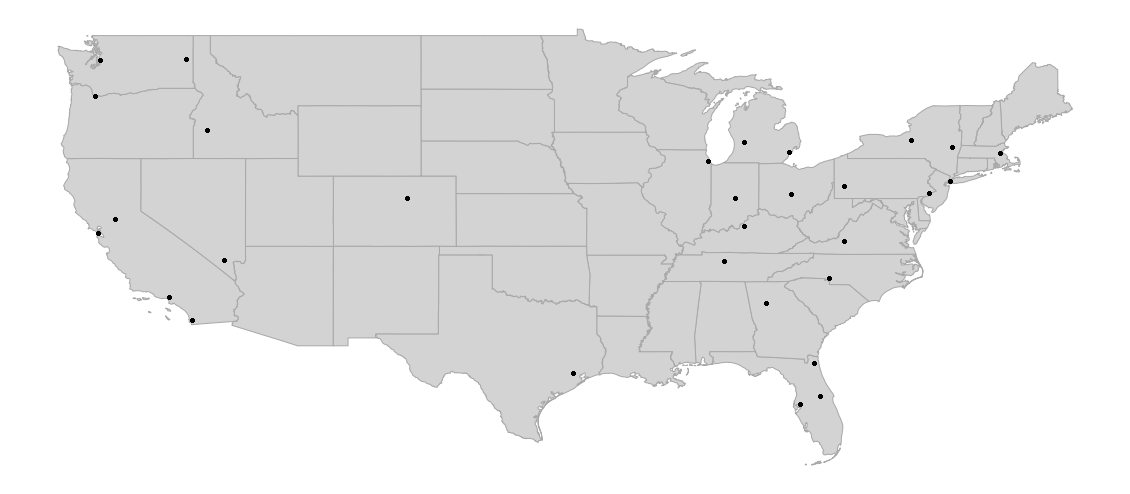

In [8]:
###Plotting###

fig, ax = plt.subplots(1, figsize=(20, 20))

country.plot(color='#D3D3D3', ax=ax, edgecolor='#A9A9A9')
data.plot(color='black', markersize=10, ax=ax)
plt.axis('off')

In [9]:
###Machine Learning###

data1 = data[['Date', 'AveragePrice', 'Total Volume', 'city', 'year', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'population', 'density']]

features = data1.loc[:, data1.columns != 'AveragePrice']
labels = data1['AveragePrice']
features = pd.get_dummies(features)

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.25)

model = DecisionTreeRegressor()
model.fit(features_train, labels_train)

train_predictions = model.predict(features_train)
test_predictions = model.predict(features_test)

train_acc = mean_squared_error(labels_train, train_predictions)
train_acc

3.241538893906196e-34

In [10]:
test_acc = mean_squared_error(labels_test, test_predictions)